# Chapter 6: 

# Bayesian Optimization for Turning Hyper-parameters

Trong chương 2 chúng ta đã  biết ba phương pháp tinh chỉnh tham số cho các mô hình ML. Chiến lược Grid Search sẽ liệt kê ra tất cả các sự kết hợp có thể có của các tham số rồi tìm kiếm một sự kết hợp cụ thể nào đó của tham số sao cho lượng phân loại của mô hình là cao nhất. Như vậy nếu chúng ta lựa chọn chỉ 5 tham số (con số này vẫn còn ít so với các tham số có thể tinh chỉnh) và mỗi một tham số chọn 10 ứng viên và sử dụng 5 folds cho Cross-Validation thì tổng số các mô hình mà máy tính sẽ phải chạy là 5×10^5 = 500.000 mô hình (nếu lựa chọn refit = False). Để cắt giảm thời gian huấn luyện chúng ta có thể thực hiện tinh chỉnh tham số theo kiểu hên - xui bằng cách chỉ chọn ngẫu nhiên, chẳng hạn, 50000 (tức là 10% của 500.000) sự kết hợp khác nhau của tham số để tinh chỉnh mô hình. Cách thức tinh chỉnh hên xui này gọi là Random Search. Chiến lược tinh chỉnh này là chúng ta có thể cắt giảm đáng kể thời gian tinh chỉnh với các giá phải trả là chúng ta có thể "bỏ sót" tham số tốt nhất của mô hình ML. Tuy vậy trong một số tình huống thì tinh chỉnh theo Random Seach có thể vẫn là không hiệu quả và chúng ta cần một chiến lược tinh chỉnh hiệu quả hơn là Bayesian Optimization. 

Trong chương này chúng ta sẽ so sánh các phương pháp tinh chỉnh tham số khác nhau là Grod Search, Random Search và Bayesian Optimization căn cứ vào ba tiêu chí: 

- Thời gian tinh chỉnh. 
- AUC trung bình từ 5-folds Cross-Validation. 
- AUC trên Test Data. 



# 6.1 Nhắc lại Grid và Random Search

Để minh họa chúng ta trở lại với bộ dữ liệu **GermanCredit.csv** với mô hình Random Forest (RF) và tiêu chí được chọn để tinh chỉnh mô hình là ROC/AUC: 

In [1]:
#=====================
#  Chuẩn bị dữ liệu
#=====================

# Load một số packages: 
import pandas as pd
import numpy as np

# Import dữ liệu và thực hiện xử lí sơ bộ: 
df_bank = pd.read_csv("C:/Users/ADMIN/Desktop/DataMining/dmba/GermanCredit.csv")
df_bank['RESPONSE'] = df_bank['RESPONSE'].map({1: 0, 0: 1})

# Bỏ biến không cần thiết: 
my_df_binary = df_bank.drop(["OBS#"], axis=1) 

# Tách ra features và target: 
Y = my_df_binary["RESPONSE"]
X = my_df_binary.drop("RESPONSE", 1)

# Phân chia dữ liệu theo tỉ lệ 80 - 20: 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=29, stratify = Y)

Thực hiện tinh chỉnh theo ROC/AUC bằng Grid Search: 

In [2]:
#==================================
#   Tinh chỉnh bằng Grid Search
#==================================

# Thiết lập lưới tinh chỉnh (liệt kê các ứng viên tiềm năng của tham số để tinh chỉnh): 
param_grid = {"max_depth": [1, 2, 3, 5, 7, 10],
              "n_estimators": [100, 150, 200, 250, 300, 500, 700, 900],
              "min_samples_split": [2, 3, 4, 5, 7, 10],
              "min_samples_leaf": [2, 3, 4, 5, 7, 10],
              "criterion": ["gini", "entropy"]}

# Thực hiện tinh chỉnh bằng Grid Search và tính luôn thời gian thực hiện: 
import time

# Thời gian bắt đầu: 
start_time = time.time()

# Huấn luyện - tinh chỉnh RF: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=29),
                       param_grid = param_grid,    
                       scoring="roc_auc",
                       refit = False, 
                       verbose = 2, 
                       cv = 5, 
                       n_jobs = -1) 

rf_grid.fit(X_train, y_train)

time_training_GridSearch = time.time() - start_time
# Hiển thị thời gian cần thiết để tinh chỉnh: 
print('Training Time:', time_training_GridSearch)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 285 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 568 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 933 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1378 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 1905 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 3201 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 3970 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 4821 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5752 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6765 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 7858 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9033 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 10288 tasks      

Training Time: 343.29314613342285


[Parallel(n_jobs=-1)]: Done 17280 out of 17280 | elapsed:  5.7min finished


Mất chừng 330s để chạy 5*3456 = 17280 mô hình RF trên con máy Workstation Dell T5610 sử dụng 2 CPU Intel Xeon E5 2680 V2, 64 Gi RAM ECC. Dưới đây là tham số tốt nhất và ROC/AUC trung bình (cho 5 folds) tương ứng: 

In [3]:
# Tham số tối ưu và Accuracy trung bình tương ứng: 
best_params_GridSearch = rf_grid.best_params_
avgAUC_GridSearch = rf_grid.best_score_

print("Tham số tối ưu:", best_params_GridSearch)
print("Accuracy trung bình tương ứng của 5 folds:", avgAUC_GridSearch)

Tham số tối ưu: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 250}
Accuracy trung bình tương ứng của 5 folds: 0.8002232142857143


In [4]:
# Huấn luyện lại RF với tham số tốt nhất: 
best_rf_Grid = RandomForestClassifier(**rf_grid.best_params_, random_state=29).fit(X_train, y_train)

# Hàm tính ROC/AUC: 
from sklearn.metrics import roc_auc_score

def calculate(model_seleted):
    auc = roc_auc_score(y_test, model_seleted.predict_proba(X_test)[:, 1])
    return auc

# AUC trên Test Data ứng với tham số tối ưu: 
auc_Grid_testData = calculate(best_rf_Grid)
auc_Grid_testData

0.7832142857142856

Với Random Search thì thời gian tinh chỉnh và huấn luyện là 54s: 

In [5]:
# Thực hiện Random Search: 
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()

rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=29),
                               param_distributions=param_grid,
                               cv=5,              
                               n_iter=50,         
                               scoring="roc_auc",
                               verbose = 2, 
                               n_jobs=-1,           
                               random_state=29)

# Tinh chỉnh bằng Random Search: 
rf_random.fit(X_train, y_train)

# Hiển thị thời gian cần thiết để tinh chỉnh: 
time_training_RandSearch = time.time() - start_time
print('Training Time:', time_training_RandSearch)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    5.2s finished


Training Time: 5.989135265350342


Các kết quả tương ứng là: 

In [6]:
best_params_RandSearch = rf_random.best_params_
avgAUC_RandSearch = rf_random.best_score_
print(rf_random.best_params_)  
print(rf_random.best_score_) 

{'n_estimators': 500, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'entropy'}
0.7966889880952381


Có thể thấy AUC = 0.7939 thua kém không đáng kể so với AUC = 0.7947 của phương án Grid Search nhưng thời gian thực thi rất nhanh. Tương tự chúng ta tính AUC trên test data tương ứng với tham số tối ưu tìm được từ Random Search: 

In [7]:
# Huấn luyện lại RF với tham số tốt nhất: 
best_rf_Ran = RandomForestClassifier(**rf_random.best_params_, random_state=29).fit(X_train, y_train)

# AUC trên Test Data ứng với tham số tối ưu: 
auc_Ran_testData = calculate(rf_random)
auc_Ran_testData

0.7836904761904762

Các kết quả thực nghiệm ở trên cho thấy Random Search có thể là một giải pháp hiệu quả cho tinh chỉnh - tìm kiếm tham số tối ưu. Tuy nhiên trong nhiều tình huống như có hàng triệu đến hàng chục triệu sự kết hợp khác nhau của các tham số (hoặc bộ dữ liệu rất lớn) thì Random Search cũng có thể là không phù hợp. Trong tình huống này chúng ta sử dụng một cách tiếp cận khác để tinh chỉnh - tìm kiếm tham số tối ưu. Phương pháp đó gọi là **Bayesian Optimization**. Trước hết chúng ta cần làm quen với thuật toán tối ưu này. 

# 6.2 Sơ lược về Bayesian Optimization

Để minh họa chúng ta xét tam thức bậc hai sau: 
$$y= x^{2} -2x + 3$$

Với kiến thức phổ thông chúng ta có thể tìm ra ngay tại x = 1 thì giá trị của y sẽ là cực tiểu và giá trị cực tiểu đó là y = 2.  Chúng ta có thể minh họa đồ thị của tam thức bậc hai này trong khoảng giá trị từ -10 đến 12 như sau: 

Minimum of 2.0000 occurs at 1.0001


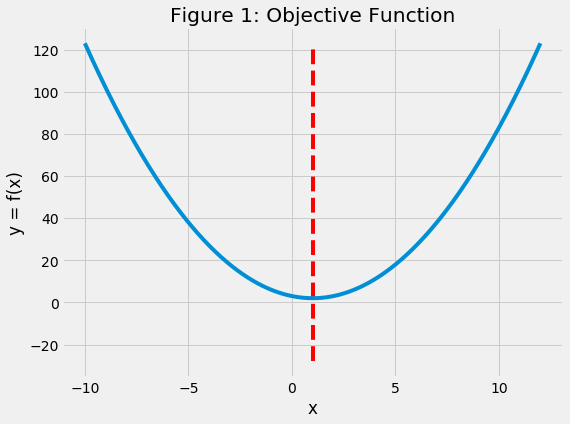

In [8]:
import numpy as np

# Viết hàm tính giá trị của y khi biết x:
def my_fun(x):
    fx = x**2 - 2*x + 3
    return fx

x = np.linspace(-10, 12, 100000) # Tạo 100000 giá trị của x trong khoảng -10 đến 12. 
y = my_fun(x) # Giá trị tương ứng của y. 

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

plt.figure(figsize = (8, 6))
plt.plot(x, y)
plt.vlines(minx, min(y) - 30, max(y), linestyles = '--', colors = 'r')
plt.title('Figure 1: Objective Function')
plt.xlabel('x')
plt.ylabel('y = f(x)')

# In ra các kết quả: 
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

Theo ngôn ngữ chuyên môn trong bối cảnh của Bayesian Optimization thì hàm my_fun mà chúng ta viết ở trên gọi là hàm mục tiêu **Objective Function** còn 100.000 các giá trị khác nhau của x gọi là **domain space** - tạm dịch là không gian tìm kiếm. Để thực hiện Bayesian Optimization chúng ta phải có hai bước không thể bỏ qua: 

- Định nghĩa hàm mục tiêu. Hàm mục tiêu có thể là bất cứ cái gì chứ không nhất thiết là tam thức bậc hai. 
- Xác định rõ không gian tìm kiếm. 

Hàm mục tiêu thì chúng ta đã xác định đó là hàm *my_fun*. Tuy nhiên để thực hiện tối ưu hóa Bayesian bằng thư viện **hyperopt** thì chúng ta thực hiện như sau: 

In [9]:
# Gọi thư viện hyperopt: 
from hyperopt import hp

# Định nghĩa không gian tìm kiếm là từ -10 đến 12: 
space = hp.uniform('x', -10, 12)

Với định nghĩa rằng các giá trị của x trong khoảng -10 đến 12 có phân phối xác suất theo luật Uniform. Chúng ta có thể xem phân phối của các giá trị x này với giả định rằng khoảng được chia thành 100000 điểm: 

Text(0.5, 1.0, 'Figure 2: Distribution of Domain Space')

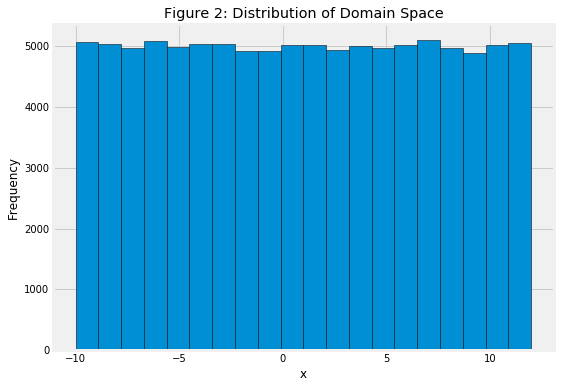

In [10]:
from hyperopt.pyll.stochastic import sample

samples = []

# Tạo 100000 giá trị của x trong khoảng -10 đến 10 với phân phối Uniform: 
for _ in range(100000):
    samples.append(sample(space))
    
# Vẽ Histogram: 
plt.figure(figsize = (8, 6))
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x')
plt.ylabel('Frequency')
plt.title('Figure 2: Distribution of Domain Space')

Với thư viện hyperopt chúng ta có hai thuật toán tối ưu khác nhau với tốc độ hội tụ khác nhau là **Random** và **Tree Parzen Estimator - TPE**. Chúng ta có thể so sánh tốc độ và kết quả của hai thuật toán tối ưu này: 

In [11]:
# Sử dụng hai thuật toán tối ưu Bayesion: 
from hyperopt import rand, tpe
tpe = tpe.suggest
rand = rand.suggest

In [12]:
# Khởi tạo Trial tương ứng cho các thuật toán tối ưu: 

from hyperopt import Trials
tpe_trials = Trials()
rand_trials = Trials()

In [13]:
# Thực hiện thuật toán tối ưu hóa: 
from hyperopt import fmin

# Run với 1000 bước cho TPE: 
tpe_best = fmin(fn=my_fun, 
                space=space, 
                algo=tpe, 
                trials=tpe_trials, 
                max_evals=1000, 
                rstate= np.random.RandomState(29))

# Kết quả: 
print(tpe_best)

100%|██████████| 1000/1000 [00:06<00:00, 165.26it/s, best loss: 2.000004745536198]
{'x': 0.9978215748353693}


In [14]:
# Tương tự là cho Random: 
rand_best = fmin(fn=my_fun, 
                 space=space, 
                 algo=rand, 
                 trials=rand_trials, 
                 max_evals=1000, 
                 rstate= np.random.RandomState(29))

print(rand_best)

100%|██████████| 1000/1000 [00:01<00:00, 969.45it/s, best loss: 2.000042623993633]
{'x': 0.9934712946434345}


Random cần thực hiện 650 bước để tìm ra giá trị tối ưu là 0.9935 từ Domain Space. Còn TPE thì chỉ cần 330 bước và giá trị tối ưu là 0.9978. Nói cách khác, tốc độ hội tụ - hay tìm nghiệm tối ưu của TPE là nhanh hơn: 

In [15]:
print('Minimum loss attained with TPE:    {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss attained with random: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x):            {:.4f}'.format(miny))

print('\nNumber of trials needed to attain minimum with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from Random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(minx))

Minimum loss attained with TPE:    2.0000
Minimum loss attained with random: 2.0000
Actual minimum of f(x):            2.0000

Number of trials needed to attain minimum with TPE:    328
Number of trials needed to attain minimum with random: 650

Best value of x from TPE:    0.9978
Best value of x from Random: 0.9935
Actual best value of x:      1.0001


TPE hội tụ nhanh hơn thì cũng có cái giá phải trả đó là thời gian: thuật toán này chạy lâu hơn. Dưới đây là Python Codes áp dụng Bayesian Optimization để tinh chỉnh tham số cho Random Forest.

# 6.3 Sử dụng Bayesian Optimization để tinh chỉnh tham số 

Random Forest (RF) được lựa chọn để minh họa quá trình thực hiện tinh chỉnh tham số bằng tối ưu hóa Bayesian. Vì mục tiêu của tinh chỉnh tham số là, ví dụ, tối đa hóa ROC/AUC nên trước tiên chúng ta cần định nghĩa hàm mục tiêu là **tối thiểu hóa giá trị của -ROC/AUC**: 

In [16]:
# Viết hàm mục tiêu là tối thiểu hóa -1*AUC: 
from sklearn.model_selection import cross_val_score

def objective_function(params):
    clf = RandomForestClassifier(**params, n_jobs = -1, random_state=29)
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="roc_auc").mean()
    loss_value = -1*score
    return loss_value

Bước kế tiếp là chúng ta phải định nghĩa Domain Space. Giả sử chúng ta chỉ muốn tinh chỉnh 5 tham số với không gian giá trị của các tham số như sau: 

In [17]:
# Xác định Domain Space cho tinh chỉnh: 
from hyperopt.pyll import scope

param_hyperopt_rf = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 50, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 1000, 100)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 30, 1)), 
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 2, 30, 1)),
    'criterion': hp.choice('criterion', ['gini', 'entropy'])
}

Thực hiện tinh chỉnh tham số cho RF bằng tối ưu hóa Bayesian: 

In [18]:
# Tắt các cảnh báo cho đỡ vướng màn hình hiển thị: 

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Tinh chỉnh tham số cho RF theo TPE: 
tpe_RF_trials = Trials()

start_time = time.time()
rf_bayesian_TPE = fmin(objective_function, 
                       param_hyperopt_rf, 
                       algo=tpe, 
                       max_evals=15, 
                       trials=tpe_RF_trials,
                       rstate= np.random.RandomState(1))
time_training_BayesianTPE = time.time() - start_time

100%|██████████| 15/15 [01:29<00:00,  5.08s/it, best loss: -0.7981026785714285]


Chúng ta có thể theo dõi trung bình AUC theo Interration cho TPE Bayesian Optimization: 

No handles with labels found to put in legend.


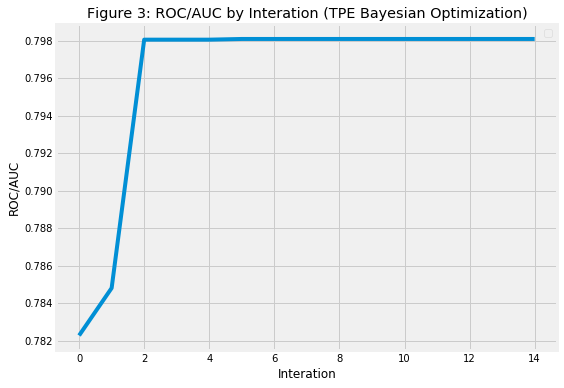

In [19]:
hyperopt_scores = [-1*trial['result']['loss'] for trial in tpe_RF_trials.trials]
hyperopt_scores = np.maximum.accumulate(hyperopt_scores)

plt.figure(figsize = (8, 6))
plt.plot(hyperopt_scores)
plt.xlabel("Interation")
plt.ylabel("ROC/AUC")
plt.title("Figure 3: ROC/AUC by Interation (TPE Bayesian Optimization)")
plt.legend()
plt.show()

In [20]:
# Giá trị các tham số tối ưu tìm được từ TPE Bayesian Optimization: 
rf_bayesian_TPE

{'criterion': 1,
 'max_depth': 29.0,
 'min_samples_leaf': 3.0,
 'min_samples_split': 12.0,
 'n_estimators': 900.0}

In [21]:
# Chuyển kết quả về list: 
best_param_values_tpe = [x for x in rf_bayesian_TPE.values()]

In [22]:
# Hàm huấn luyện RF với tham số tốt nhất và tính ROC/AUC cho train data: 

def training_calculatingAUC(best_param_values):
    
    if best_param_values[0] == 0:
        criterion = 'gini'
    else:
        criterion = 'entropy'
        
    best_rf = RandomForestClassifier(criterion = criterion, 
                                     max_depth = int(best_param_values[1]), 
                                     min_samples_leaf = int(best_param_values[2]), 
                                     min_samples_split = int(best_param_values[3]), 
                                     n_estimators = int(best_param_values[4]), 
                                     n_jobs = -1)
    
    best_rf.fit(X_train, y_train)
    auc = calculate(best_rf)
    print("AUC tương ứng với tham số tối ưu trên Train Data:", round(auc, 3))
    return best_rf

In [23]:
# Huấn luyện lại RF sử dụng tham số tốt nhất từ TPE Bayesian Optimization: 
best_rf_TPE = training_calculatingAUC(best_param_values=best_param_values_tpe)

AUC tương ứng với tham số tối ưu trên Train Data: 0.79


In [32]:
avgAUC_TPE_Bayesian = max(hyperopt_scores) # AUC trung bình (cho 5 folds) cao nhất. 
auc_TPE_Bayesian_testData = 0.79 # AUC trên Test Data. 

Dưới đây là Python Codes cho thực hiện Bayesian Optimization theo chiến lược Random: 

In [25]:
ran_RF_trials = Trials()

start_time = time.time()
rf_bayesian_Rand = fmin(objective_function, 
                        param_hyperopt_rf, 
                        algo=rand, 
                        max_evals=25, 
                        trials=ran_RF_trials,
                        rstate= np.random.RandomState(29))
time_training_BayesianRand = time.time() - start_time

100%|██████████| 25/25 [02:33<00:00,  4.88s/it, best loss: -0.7990327380952381]


No handles with labels found to put in legend.


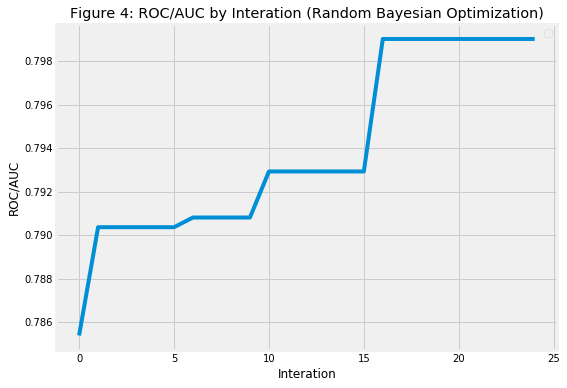

In [26]:
hyperopt_scores_ran = [-1*trial['result']['loss'] for trial in ran_RF_trials.trials]
hyperopt_scores_ran = np.maximum.accumulate(hyperopt_scores_ran)

plt.figure(figsize = (8, 6))
plt.plot(hyperopt_scores_ran)
plt.xlabel("Interation")
plt.ylabel("ROC/AUC")
plt.title("Figure 4: ROC/AUC by Interation (Random Bayesian Optimization)")
plt.legend()
plt.show()

In [27]:
avgAUC_TPE_Rand = max(hyperopt_scores_ran)

In [28]:
best_param_values_ran = [x for x in rf_bayesian_Rand.values()]

In [29]:
best_rf_Rand = training_calculatingAUC(best_param_values=best_param_values_ran)

AUC tương ứng với tham số tối ưu trên Train Data: 0.788


In [30]:
rf_bayesian_Rand

{'criterion': 1,
 'max_depth': 45.0,
 'min_samples_leaf': 2.0,
 'min_samples_split': 5.0,
 'n_estimators': 700.0}

In [33]:
auc_Ran_Bayesian_testData = 0.788

# 6.4 So sánh kết quả tinh chỉnh 

Hiệu quả tinh chỉnh tham số cho RF được đánh giá từ ba khía cạnh là: (1) thời gian tinh chỉnh, (2) trung bình AUC cao nhất trên 5 folds, và (3) AUC trên test data tương ứng với tham số tốt nhất thu được từ các phương pháp tinh chỉnh: 

In [35]:
df_comparing = {'Turning Method': ['Grid Search', 'Random Search', 'TPE Bayesian', 'Random Bayesian'], 
               'Turning Time': [time_training_GridSearch, time_training_RandSearch, time_training_BayesianTPE, time_training_BayesianRand],
               'Average AUC': [avgAUC_GridSearch, avgAUC_RandSearch, avgAUC_TPE_Bayesian, avgAUC_TPE_Rand], 
               'Test Data AUC': [auc_Grid_testData, auc_Ran_testData, auc_TPE_Bayesian_testData, auc_Ran_Bayesian_testData]}

pd.DataFrame(df_comparing)

,Turning Method,Turning Time,Average AUC,Test Data AUC
0,Grid Search,343.293146,0.800223,0.783214
1,Random Search,5.989135,0.796689,0.783690
2,TPE Bayesian,89.887230,0.798103,0.790000
3,Random Bayesian,153.594213,0.799033,0.788000


# Tài liệu tham khảo

1. Géron, A. (2019). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. O'Reilly Media, Inc.
2. Shmueli, G., Bruce, P. C., Yahav, I., Patel, N. R., & Lichtendahl Jr, K. C. (2017). Data mining for business analytics: concepts, techniques, and applications in R. John Wiley & Sons.
3. Pelikan, M., Goldberg, D. E., & Cantú-Paz, E. (1999, July). BOA: The Bayesian optimization algorithm. In Proceedings of the 1st Annual Conference on Genetic and Evolutionary Computation-Volume 1 (pp. 525-532). Morgan Kaufmann Publishers Inc.
4. Bergstra, J., Komer, B., Eliasmith, C., Yamins, D., & Cox, D. D. (2015). Hyperopt: a python library for model selection and hyperparameter optimization. Computational Science & Discovery, 8(1), 014008.
5. Klein, A., Falkner, S., Mansur, N., & Hutter, F. (2017, December). RoBO: A flexible and robust Bayesian optimization framework in Python. In NIPS 2017 Bayesian Optimization Workshop.
6. Eggensperger, K., Feurer, M., Hutter, F., Bergstra, J., Snoek, J., Hoos, H., & Leyton-Brown, K. (2013, December). Towards an empirical foundation for assessing bayesian optimization of hyperparameters. In NIPS workshop on Bayesian Optimization in Theory and Practice (Vol. 10, p. 3).